# Patches windows and their use in interpolation

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from invwidget import inversion_widget
from scipy.signal import convolve
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.basic import cgls
from pylops.optimization.sparsity import fista
from pylops import LinearOperator, MatrixMult, MemoizeOperator
from pylops.signalprocessing import FFT2D, Sliding1D, Sliding2D, Patch2D, Patch3D
from pylops.signalprocessing.sliding1d import sliding1d_design
from pylops.signalprocessing.sliding2d import sliding2d_design
from pylops.signalprocessing.sliding3d import sliding3d_design
from pylops.signalprocessing.patch2d import patch2d_design
from pylops.signalprocessing.patch3d import patch3d_design
from pylops.utils.describe import describe

from visual import *

## 1d sliding

Let's start with the simplest scenario, where Sliding1D is simply to patch together different windows of data

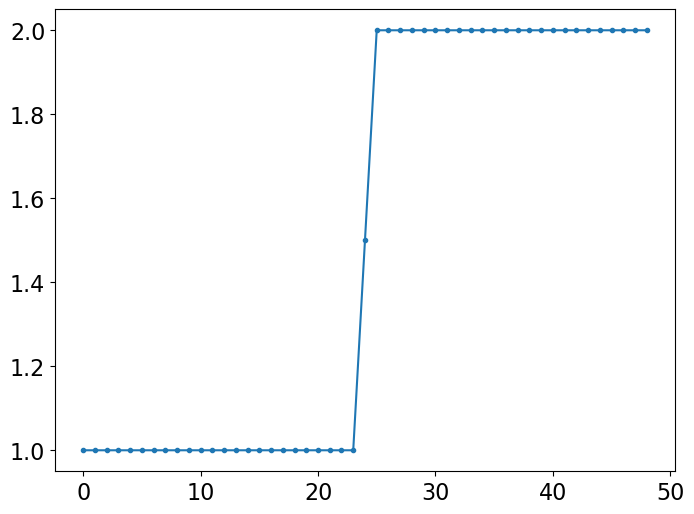

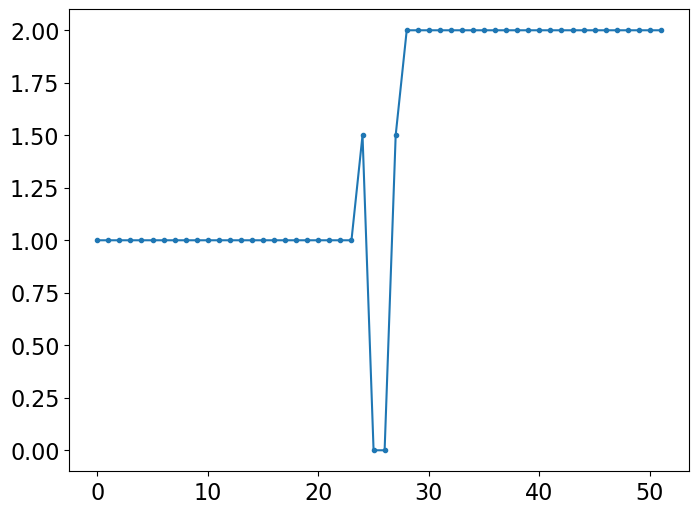

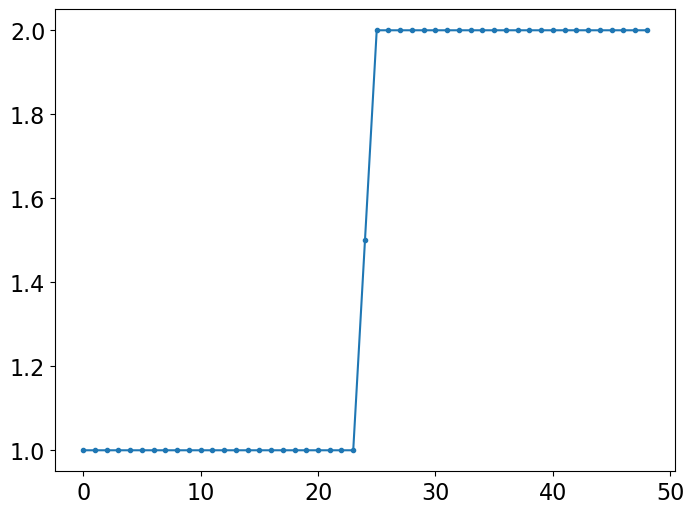

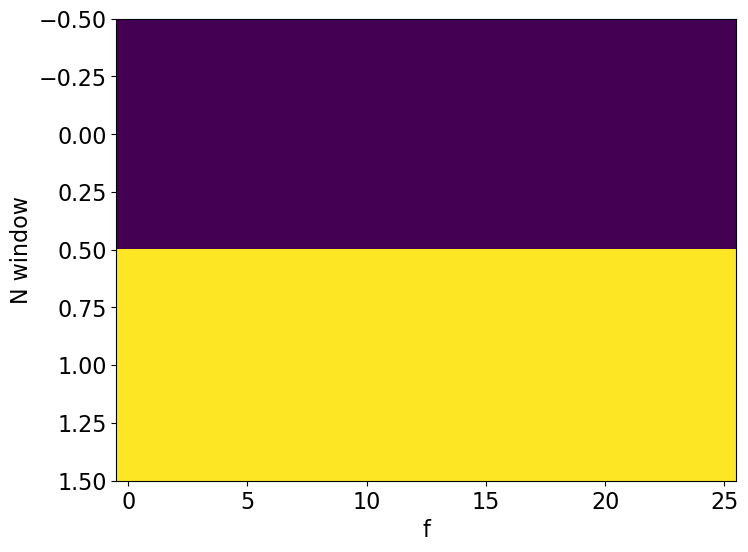

In [2]:
dimd = 49
nwin = 26
nover = 3
nwins, dim, mwin_inends, dwin_inends = sliding1d_design(dimd, nwin, nover, nwin)

Op = Identity(nwin, nwin)
Sop = Sliding1D(Op.H, dim, dimd, nwin, nover, tapertype='cosine')

x = np.ones(dim)
x[dim//2:]=2
y = Sop * x
xinv = Sop.div(y)

yinv = Sop * xinv

plt.figure()
plt.plot(y, '.-')

plt.figure()
plt.plot(xinv, '.-')

plt.figure()
plt.plot(yinv, '.-')

plt.figure()
plt.imshow(np.abs(x.reshape(Sop.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

We make now the operator Op such that it applies to all windows at the same time. To do so, the operator must take the model, reshape it to be of size (nwins, nwin) and apply a transform over every window.

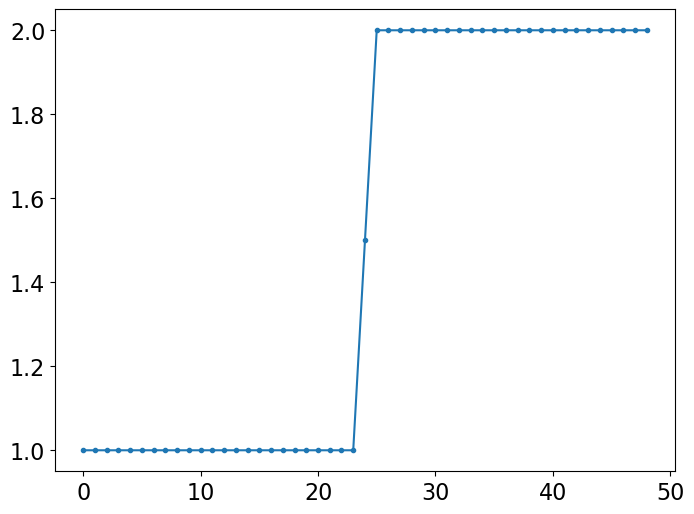

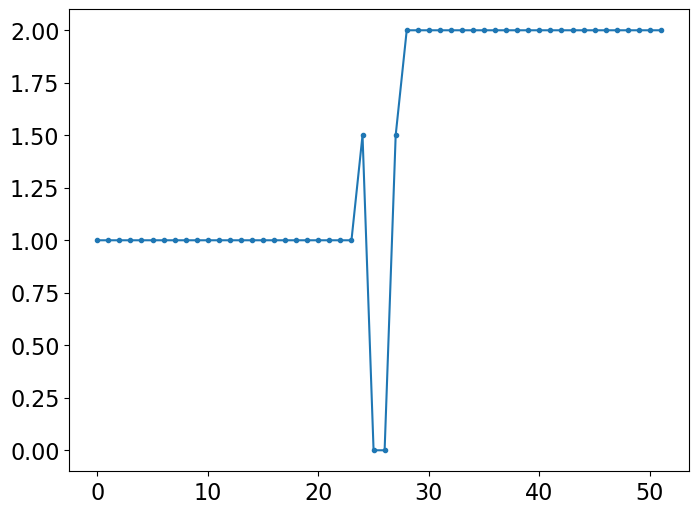

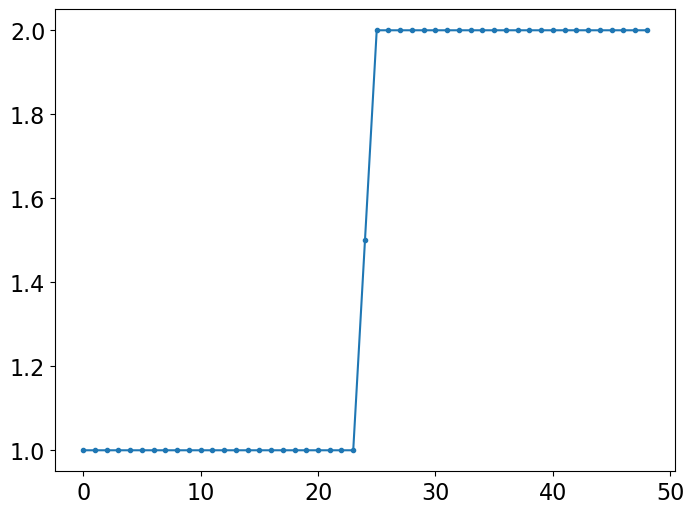

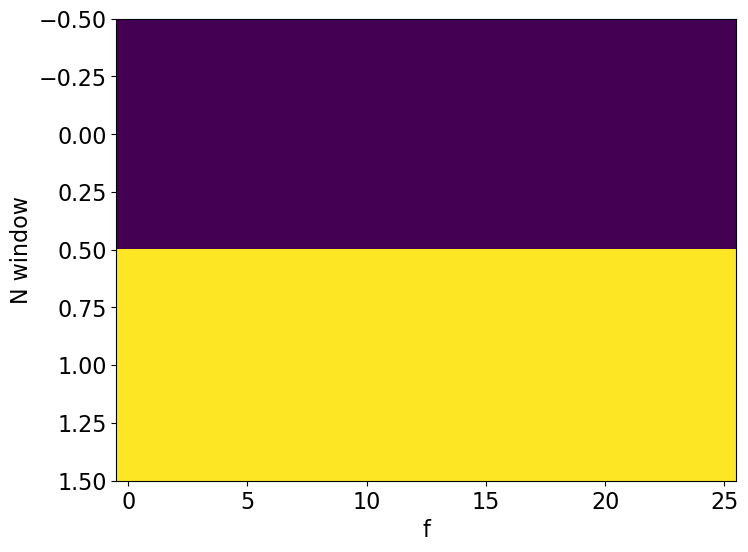

In [3]:
Op = Identity((nwins, nwin), (nwins, nwin))
Sop = Sliding1D(Op.H, dim, dimd, nwin, nover, tapertype='cosine')

xinv = Sop.div(y)

yinv = Sop * xinv

plt.figure()
plt.plot(y, '.-')

plt.figure()
plt.plot(xinv, '.-')

plt.figure()
plt.plot(yinv, '.-')

plt.figure()
plt.imshow(np.abs(x.reshape(Sop.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

We consider now the case where the patches are in a different domain. Sliding1D is now used to transform those patches to the original domain and then patch together different windows of data.

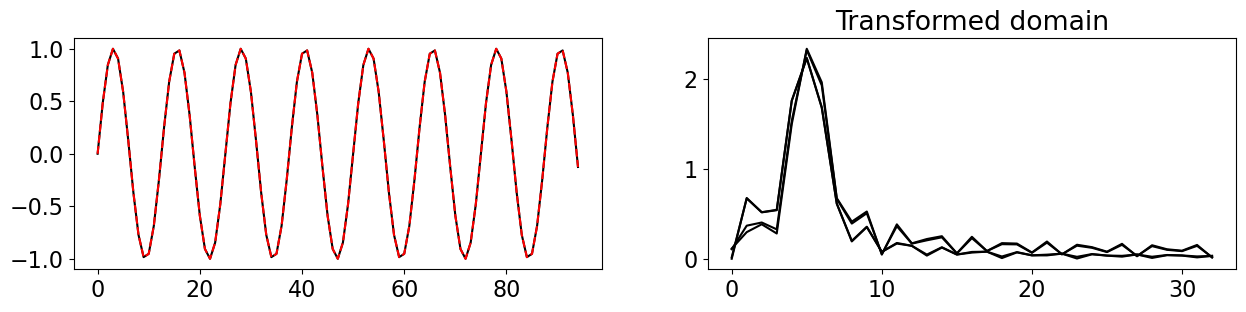

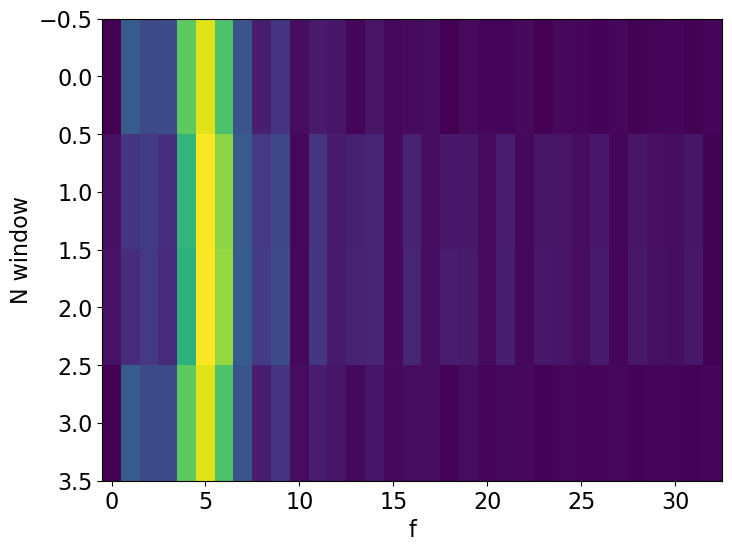

In [4]:
nwins = 4
nwin = 26
nover = 3
nop = 64
dimd = nwin * nwins - 3 * nover

t = np.arange(dimd) * 0.004
data = np.sin(2 * np.pi * 20 * t)

nwins, dim, mwin_inends, dwin_inends = sliding1d_design(dimd, nwin, nover, (nop + 2) // 2)
Op = pylops.signalprocessing.FFT(nwin, nfft=nop, real=True)
Slid = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype=None)

x = Slid.H * data.ravel()
y = Slid * x

Slid = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype="cosine"
)

reconstructed_data = Slid * x.ravel()

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(data, "k", label="Data")
axs[0].plot(reconstructed_data, "--r", label="Rec Data")
axs[1].set_title("Original domain")
axs[1].plot(np.abs(x).T, "k")
axs[1].set_title("Transformed domain")

plt.figure()
plt.imshow(np.abs(x.reshape(Slid.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

And now defining the transform such that it is applied to all patches together

True True


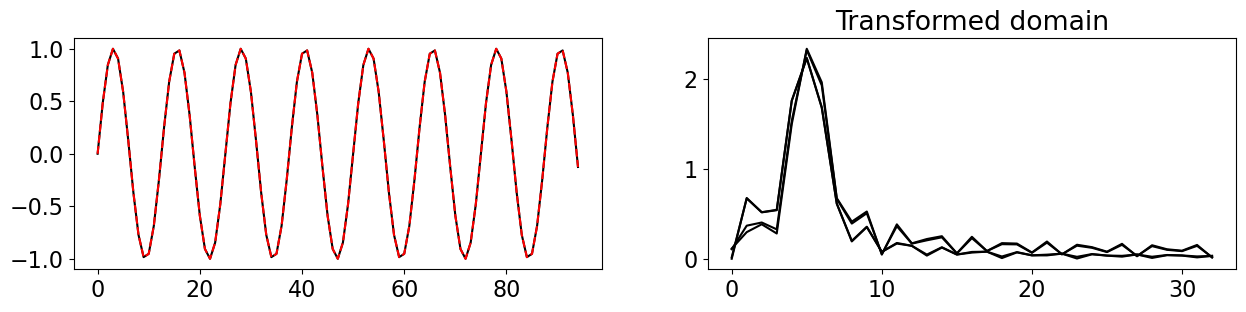

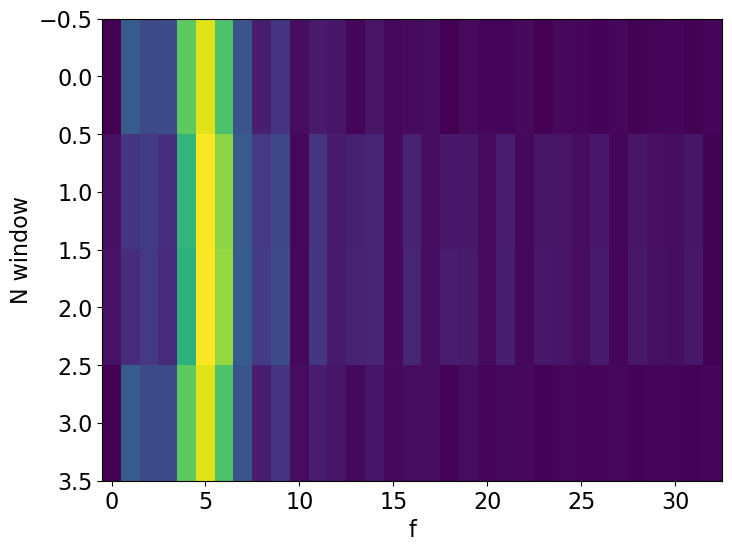

In [5]:
Op = pylops.signalprocessing.FFT((nwins, nwin), nfft=nop, axis=-1, real=True)
Slid1 = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype=None)

x1 = Slid1.H * data.ravel()
y1 = Slid1 * x1

print(np.allclose(x, x1), np.allclose(y, y1))

Slid1 = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype="cosine"
)

reconstructed_data = Slid1 * x.ravel()

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(data, "k", label="Data")
axs[0].plot(reconstructed_data, "--r", label="Rec Data")
axs[1].set_title("Original domain")
axs[1].plot(np.abs(x).T, "k")
axs[1].set_title("Transformed domain")

plt.figure()
plt.imshow(np.abs(x.reshape(Slid.dims)))
plt.xlabel('f')
plt.ylabel('N window')
plt.axis('tight');

Let's time the two approaches for a much larger data

In [6]:
nwins = 500
nwin = 26
nover = 3
nop = 64
dimd = nwin * nwins - 3 * nover

t = np.arange(dimd) * 0.004
data = np.sin(2 * np.pi * 20 * t)

nwins, dim, mwin_inends, dwin_inends = sliding1d_design(dimd, nwin, nover, (nop + 2) // 2)

Op = pylops.signalprocessing.FFT(nwin, nfft=nop, real=True)
Slid = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype=None)

Op = pylops.signalprocessing.FFT((nwins, nwin), nfft=nop, axis=-1, real=True)
Slid1 = pylops.signalprocessing.Sliding1D(
    Op.H, dim, dimd, nwin, nover, tapertype=None)

x = Slid1.H * data.ravel()

In [7]:
%timeit -n 5 -r 10 Slid.H * data.ravel()
%timeit -n 5 -r 10 Slid1.H * data.ravel()

%timeit -n 5 -r 10 Slid * x
%timeit -n 5 -r 10 Slid1 * x

4.32 ms ± 957 μs per loop (mean ± std. dev. of 10 runs, 5 loops each)
149 μs ± 20.4 μs per loop (mean ± std. dev. of 10 runs, 5 loops each)
5.32 ms ± 423 μs per loop (mean ± std. dev. of 10 runs, 5 loops each)
575 μs ± 46.1 μs per loop (mean ± std. dev. of 10 runs, 5 loops each)


## 2d sliding

In [8]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
data = data[:, 60:]
pad = 12
data = np.pad(data, ((pad, pad), (pad, pad)), mode='edge')

In [9]:
dimsd = data.shape
nwin = 26
nover = 4

Op = FFT2D((nwin, dimsd[1]), nffts=(256, 256))

nwins, dims, mwin_inends, dwin_inends = sliding2d_design(dimsd, nwin, nover, (256, 256))
Sop = Sliding2D(Op.H, dims, dimsd, nwin, nover, tapertype=None)
Sop1 = Sliding2D(Op.H, dims, dimsd, nwin, nover, tapertype='cosine')
y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshaped = x.reshape(Sop1.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 50)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

np.True_

In [10]:
Sop.name = None
describe(Sop)

V

where: {'V': 'Sliding2D'}


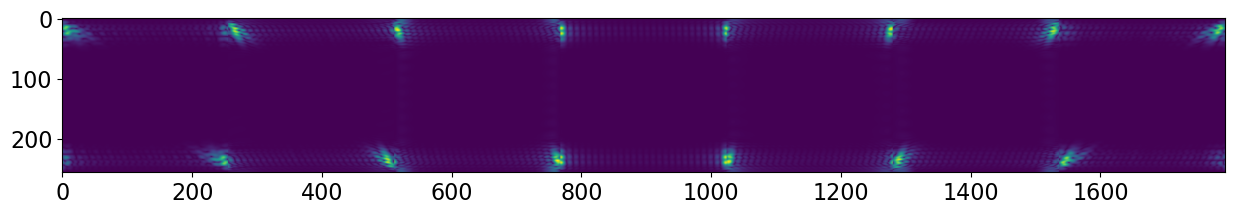

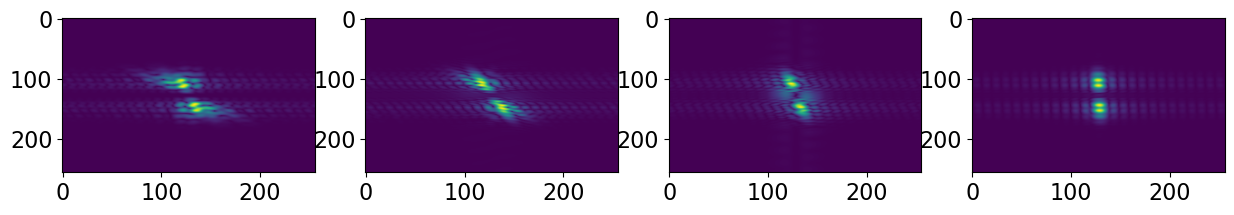

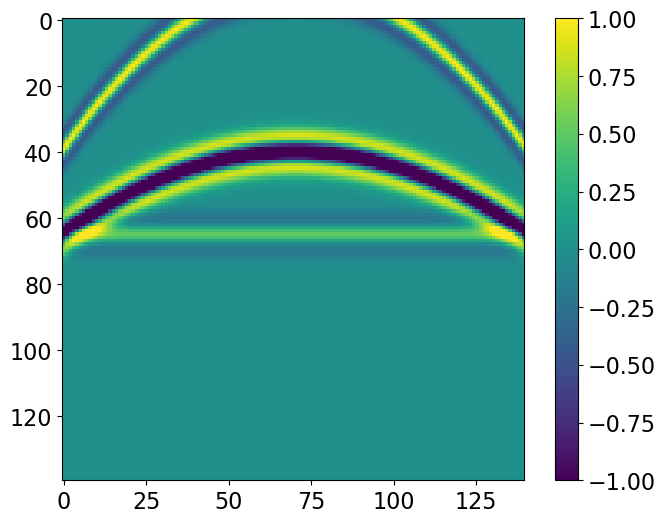

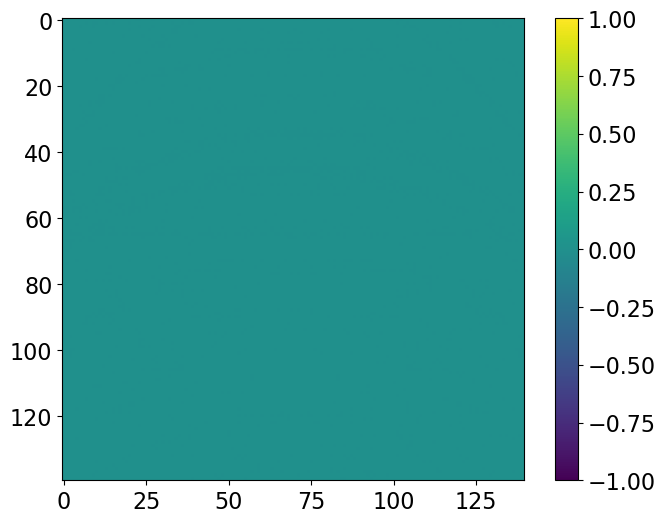

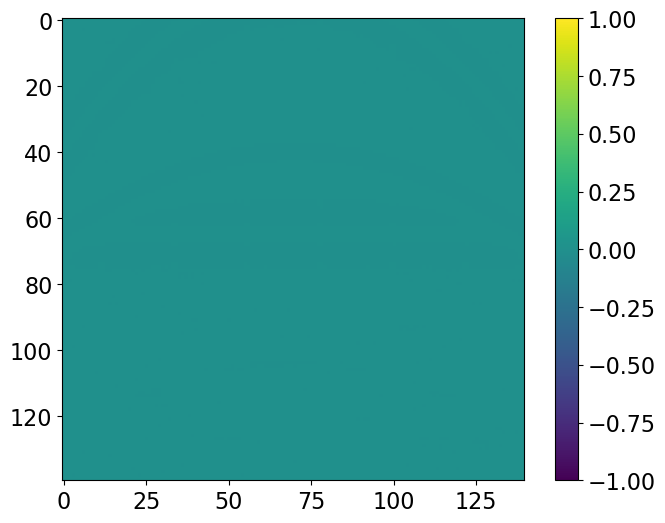

In [11]:
plt.figure(figsize=(15, 2))
plt.imshow(np.abs(x).T)
#plt.colorbar()
plt.axis('tight')

fig, axs = plt.subplots(1, 4, figsize=(15, 2))
for i in range(4):
    axs[i].imshow(np.fft.fftshift(np.abs(xreshaped[i]).T))
    axs[i].axis('tight')
          
plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-y1[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y[pad:-pad,pad:-pad].T-yinv[pad:-pad,pad:-pad].T, vmin=-1, vmax=1)
plt.colorbar();

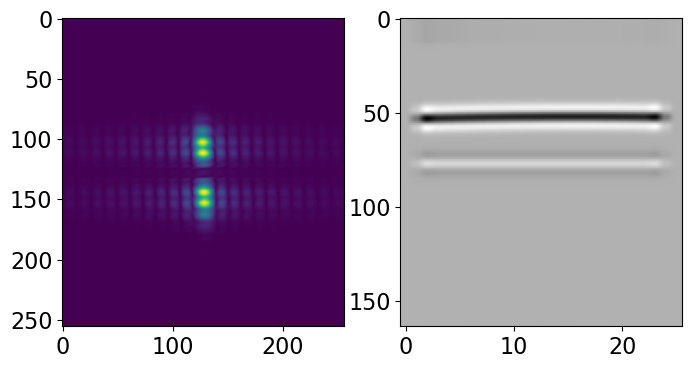

In [12]:
slides_inend = np.arange(0, 7*256*256+1, 256*256)

islide = 3

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].reshape(256, 256).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Op.H * xinv.ravel()[slides_inend[islide]:slides_inend[islide+1]].T).reshape(nwin, dimsd[1]).T), 
              cmap='gray')
axs[1].axis('tight');

And now with a single transform acting directly on all windows

In [13]:
Op = FFT2D((nwins, nwin, dimsd[1]), nffts=(256, 256))
Sop_fast = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None)
Sop1_fast = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                      tapertype='cosine')

x_fast = Sop_fast.H * y.ravel()
y1_fast = Sop1_fast * x_fast.ravel()

print(np.allclose(x.ravel(), x_fast), np.allclose(y1.ravel(), y1_fast))

True True


Finally let's compare performance

In [14]:
dimsd = (2000, 2000)
nwin = 26
nover = 4

nwins, dims, mwin_inends, dwin_inends = sliding2d_design(dimsd, nwin, nover, (256, 256))

Op = FFT2D((nwin, dimsd[1]), nffts=(256, 256))
Sop = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None)
Sop1 = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                 tapertype='cosine')

Op = FFT2D((nwins, nwin, dimsd[1]), nffts=(256, 256))
Sop_fast = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None)
Sop1_fast = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                      tapertype='cosine')
y = np.ones(dimsd)
x = Sop.H * y.ravel()
y1 = Sop1 * x.ravel()

x_fast = Sop_fast.H * y.ravel()
y1_fast = Sop1_fast * x_fast.ravel()

print(np.allclose(x.ravel(), x_fast), np.allclose(y1.ravel(), y1_fast))

True True


In [15]:
%timeit -n 2 -r 2 Sop.H * y.ravel()
%timeit -n 2 -r 2 Sop_fast.H * y.ravel()

%timeit -n 2 -r 2 Sop * x.ravel()
%timeit -n 2 -r 2 Sop_fast * x.ravel()

54.7 ms ± 2.9 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
58.4 ms ± 1.3 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
59.4 ms ± 5.9 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
72.8 ms ± 943 μs per loop (mean ± std. dev. of 2 runs, 2 loops each)


## 3d sliding

In [16]:
par = {
    "oy": -15,
    "dy": 2,
    "ny": 14,
    "ox": -18,
    "dx": 2,
    "nx": 18,
    "ot": 0,
    "dt": 0.004,
    "nt": 50,
    "f0": 30,
}

vrms = [200, 200]
t0 = [0.05, 0.1]
amp = [1.0, -2]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par["f0"])[0]

# Generate model
_, data = pylops.utils.seismicevents.hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)

# Sliding window plan
winsize = (5, 6)
overlap = (2, 3)
npx = 21
px = np.linspace(-5e-3, 5e-3, npx)
npy = 25
py = np.linspace(-5e-3, 5e-3, npy)
dimsd = data.shape

# Sliding window transform without taper
Op = pylops.signalprocessing.Radon3D(
    t,
    np.linspace(-par["dy"] * winsize[0] // 2, par["dy"] * winsize[0] // 2, winsize[0]),
    np.linspace(-par["dx"] * winsize[1] // 2, par["dx"] * winsize[1] // 2, winsize[1]),
    py,
    px,
    centeredh=True,
    kind="linear",
    engine="numba",
)

nwins, dims, mwin_inends, dwin_inends = sliding3d_design(dimsd, winsize, overlap, (npy, npx, par["nt"]))
Slid = pylops.signalprocessing.Sliding3D(
    Op, dims, dimsd, winsize, overlap, (npy, npx), tapertype=None
)

radon = Slid.H * data.ravel()
radon = radon.reshape(Slid.dims) # nwins[0], nwins[1], npx, npx, par["nt"])

Slid = pylops.signalprocessing.Sliding3D(
    Op, dims, dimsd, winsize, overlap, (npy, npx), tapertype="cosine"
)

reconstructed_data = Slid * radon.ravel()
reconstructed_data = reconstructed_data.reshape(Slid.dimsd)

radoninv = pylops.LinearOperator(Slid, explicit=False).div(data.ravel(), niter=10)
reconstructed_datainv = Slid * radoninv.ravel()

radoninv = radoninv.reshape(nwins[0], nwins[1], npy, npx, par["nt"])
reconstructed_datainv = reconstructed_datainv.reshape(dimsd)

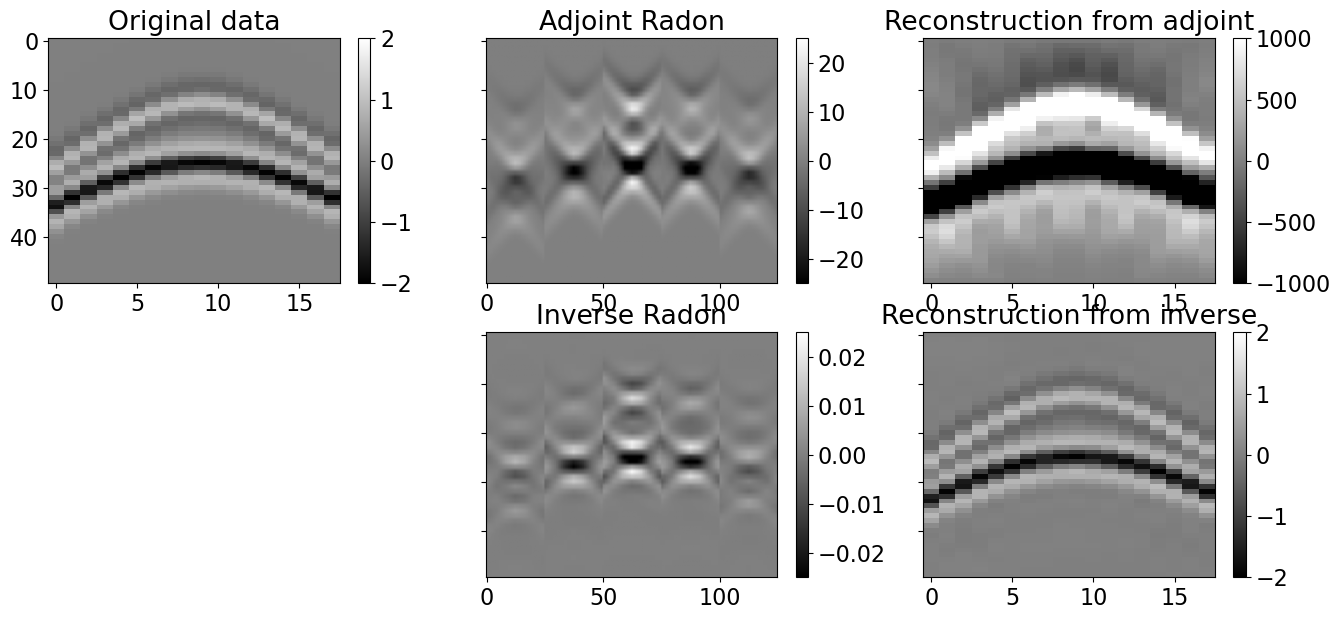

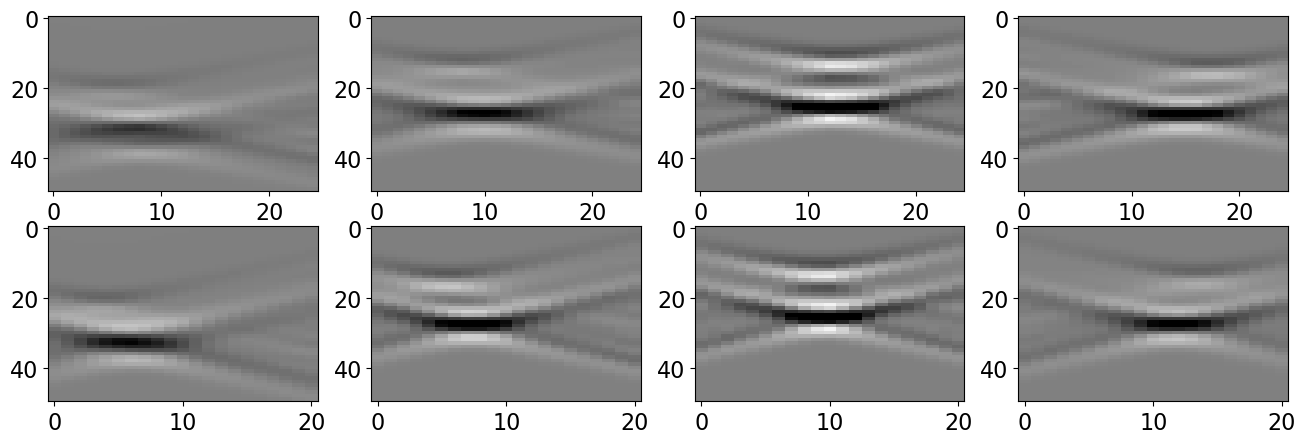

In [17]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(16, 7))
im = axs[0][0].imshow(data[par["ny"] // 2].T, cmap="gray", vmin=-2, vmax=2)
axs[0][0].set_title("Original data")
plt.colorbar(im, ax=axs[0][0])
axs[0][0].axis("tight")
im = axs[0][1].imshow(
    radon[nwins[0] // 2, :, :, npx // 2].reshape(nwins[1] * npy, par["nt"]).T,
    cmap="gray",
    vmin=-25,
    vmax=25,
)
axs[0][1].set_title("Adjoint Radon")
plt.colorbar(im, ax=axs[0][1])
axs[0][1].axis("tight")
im = axs[0][2].imshow(
    reconstructed_data[par["ny"] // 2].T, cmap="gray", vmin=-1000, vmax=1000
)
axs[0][2].set_title("Reconstruction from adjoint")
plt.colorbar(im, ax=axs[0][2])
axs[0][2].axis("tight")
axs[1][0].axis("off")
im = axs[1][1].imshow(
    radoninv[nwins[0] // 2, :, :, npx // 2].reshape(nwins[1] * npy, par["nt"]).T,
    cmap="gray",
    vmin=-0.025,
    vmax=0.025,
)
axs[1][1].set_title("Inverse Radon")
plt.colorbar(im, ax=axs[1][1])
axs[1][1].axis("tight")
im = axs[1][2].imshow(
    reconstructed_datainv[par["ny"] // 2].T, cmap="gray", vmin=-2, vmax=2
)
axs[1][2].set_title("Reconstruction from inverse")
plt.colorbar(im, ax=axs[1][2])
axs[1][2].axis("tight")


fig, axs = plt.subplots(2, 4, figsize=(16, 5))
for i in range(4):
    axs[0][i].imshow(radon[i, i, :, npx // 2].reshape(npy, par["nt"]).T,
                  cmap="gray", vmin=-25, vmax=25)
    axs[0][i].axis('tight')
    axs[1][i].imshow(radon[i, i, npy // 2].reshape(npx, par["nt"]).T,
                  cmap="gray", vmin=-25, vmax=25)
    axs[1][i].axis('tight');

## 2d patches

In [18]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
data = data[:, 40:]

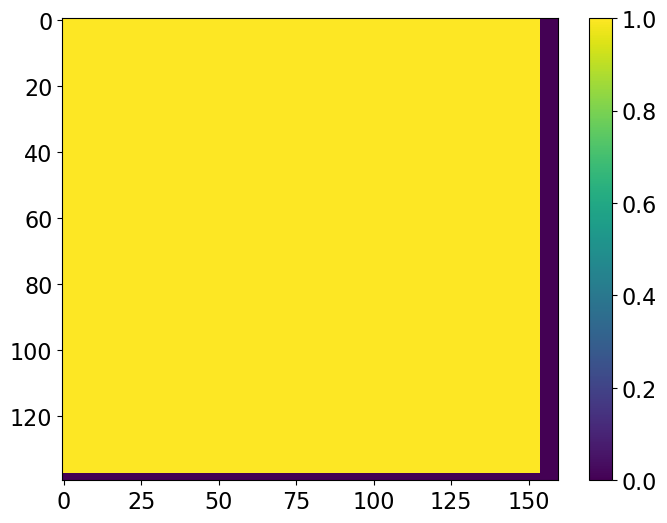

In [19]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = nwin
nwins = (4, 5)
dims = (nwins[0]*nop[0], nwins[1]*nop[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine')

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight');

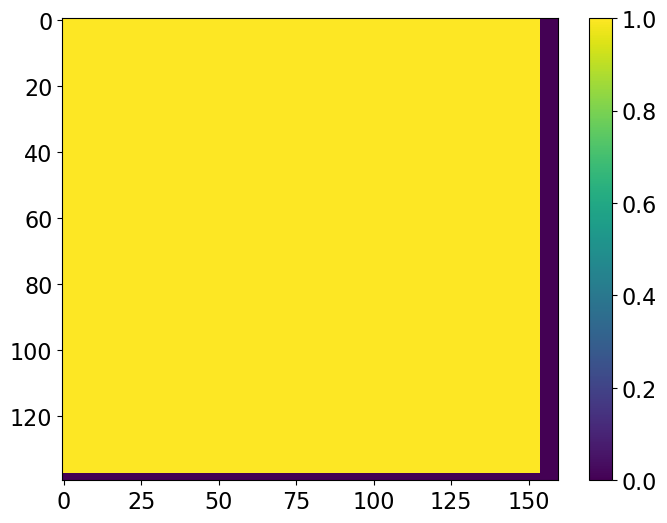

In [20]:
#with scalings
scalings = np.arange(nwins[0]*nwins[1])

Op = Identity(nwin[0]*nwin[1], nwin[0]*nwin[1])
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine', scalings=scalings)

y = Sop * np.ones(Sop.shape[1])

plt.figure()
plt.imshow(y.reshape(dimsd[0], dimsd[1]))
plt.colorbar()
plt.axis('tight');

In [21]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = (64, 64)
dims = (4*64, 5*64)

Op = FFT2D(nwin, nffts=nop)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype=None)
Sop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosine')

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshape = x.reshape(Sop.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 5)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

np.True_

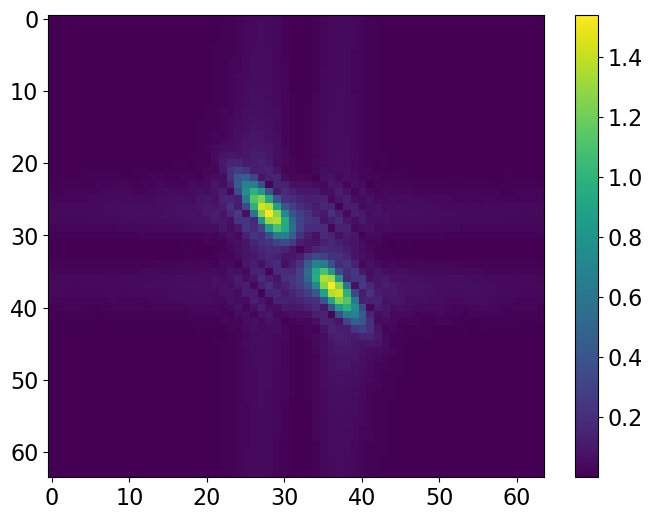

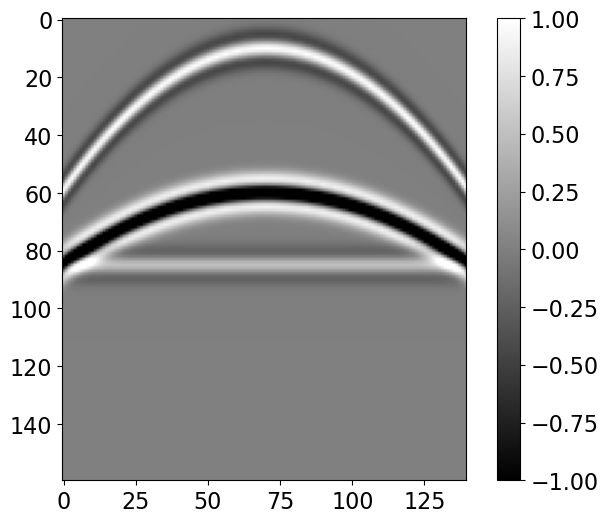

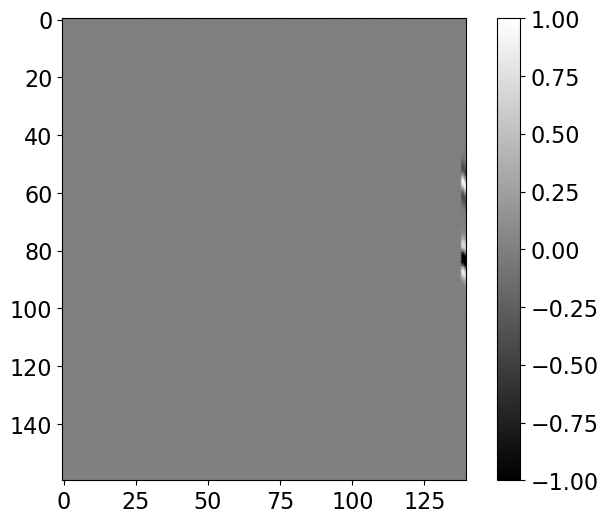

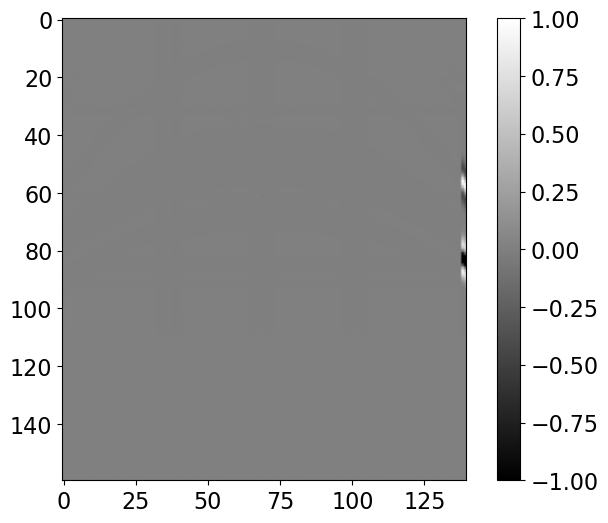

In [22]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[:nop[0]*nop[1]].reshape(nop).T)))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(y.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-y1.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-yinv.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar();

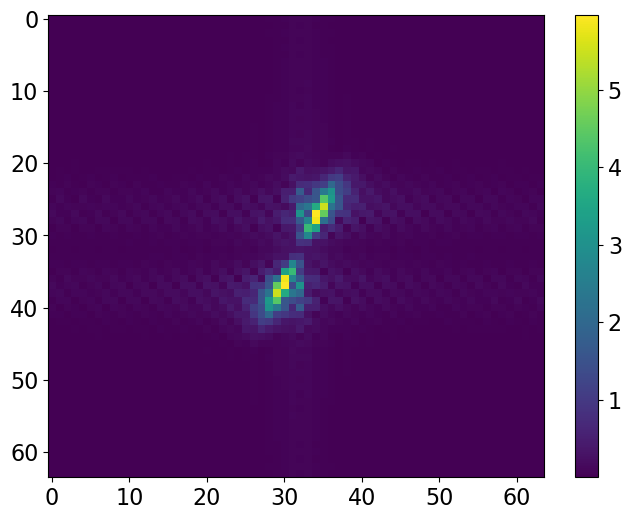

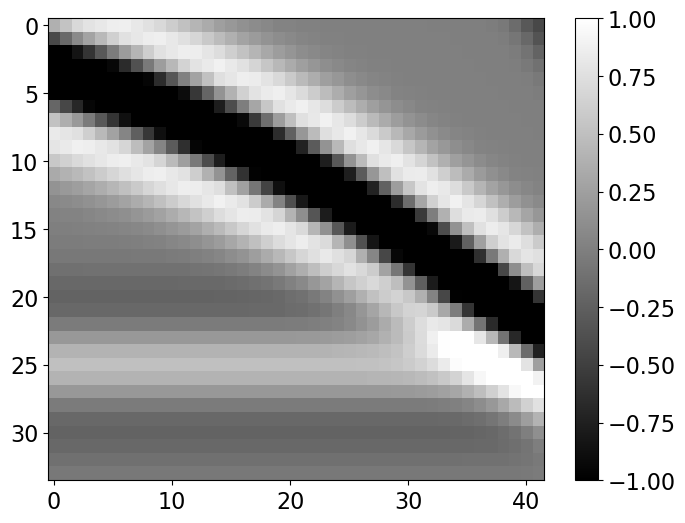

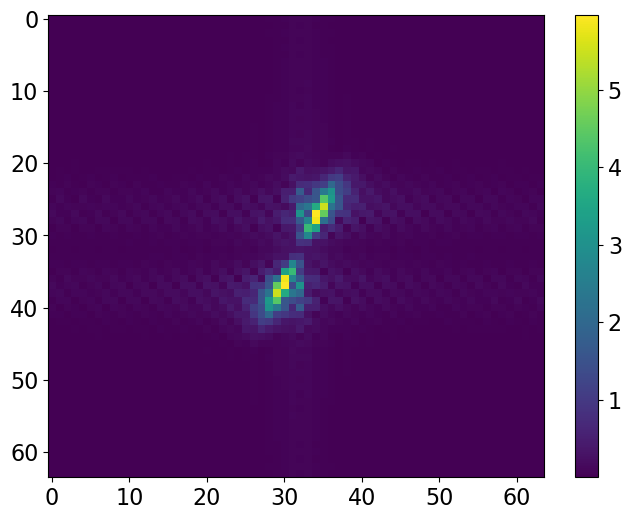

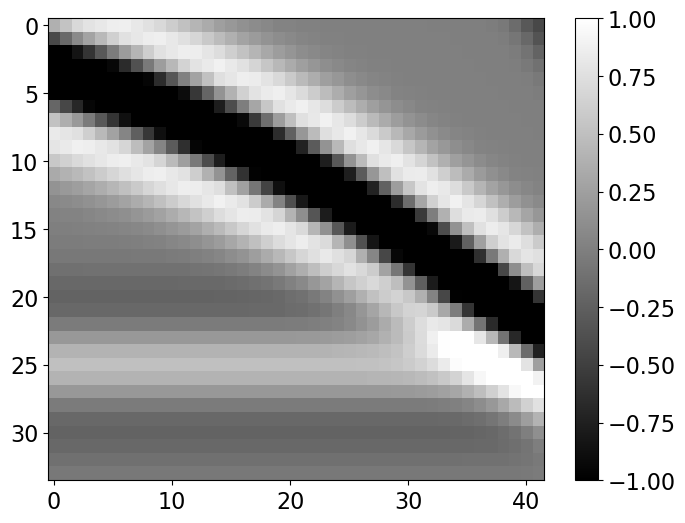

In [23]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch_x, ipatch_t = 3, 2
ipatch = ipatch_x*5 + ipatch_t

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.real((Op.H * x.ravel()[patches_inend[ipatch]:patches_inend[ipatch+1]]).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.fft.fftshift(np.abs(xreshape[ipatch_x, ipatch_t]).T))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(np.real((Op.H * xreshape[ipatch_x, ipatch_t].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
plt.colorbar()
plt.axis('tight');

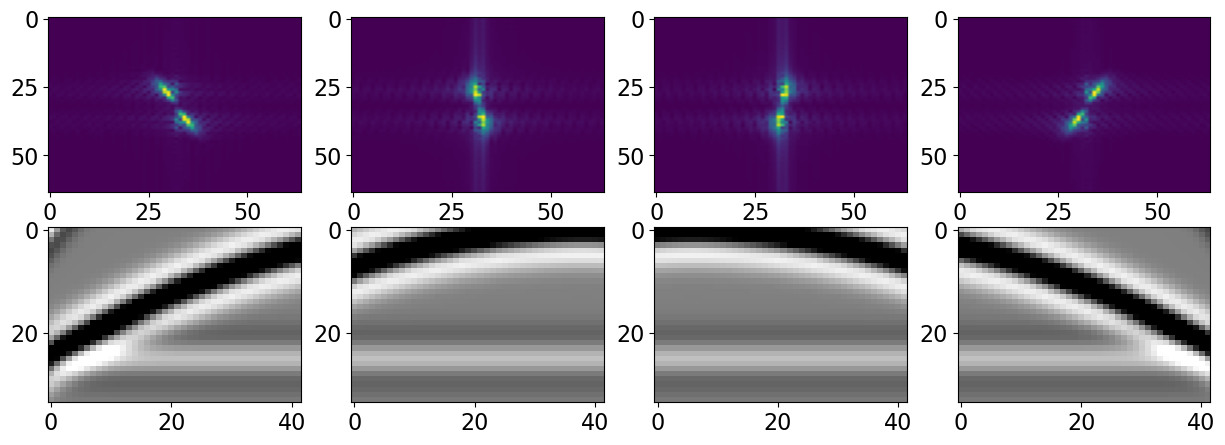

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(xreshape[i, 2]).T))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Op.H * xreshape[i, 2].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
    axs[1][i].axis('tight');

And now with only the positive frequency axis

In [25]:
dimsd = data.shape
nwin = (42, 34)
nover = (10, 4)
nop = (64, 64)
nop1 = (64, 33)
dims = (4*64, 5*33)

Op = FFT2D(nwin, nffts=nop, real=True)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop1)
Sop = Patch2D(Op.H, dims, dimsd, nwin, nover, nop1,
              tapertype=None)
Sop1 = Patch2D(Op.H, dims, dimsd, nwin, nover, nop1,
              tapertype='cosine')

y = data.copy()
x = Sop.H * y.ravel()
x = x.reshape(dims)
xreshape = x.reshape(Sop.dims)
y1 = Sop1 * x.ravel()
y1 = np.real(y1).reshape(dimsd)

xinv = Sop1.div(y.ravel(), 5)

yinv = Sop1 * xinv.ravel()
yinv = np.real(yinv).reshape(dimsd)

#dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=0, atol=1e-2)

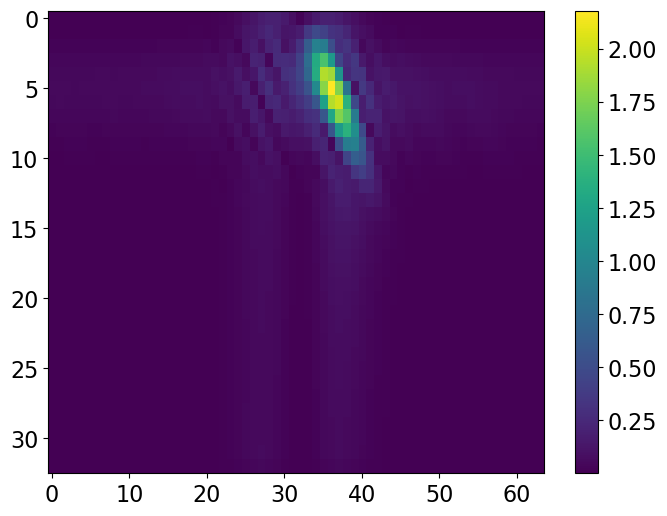

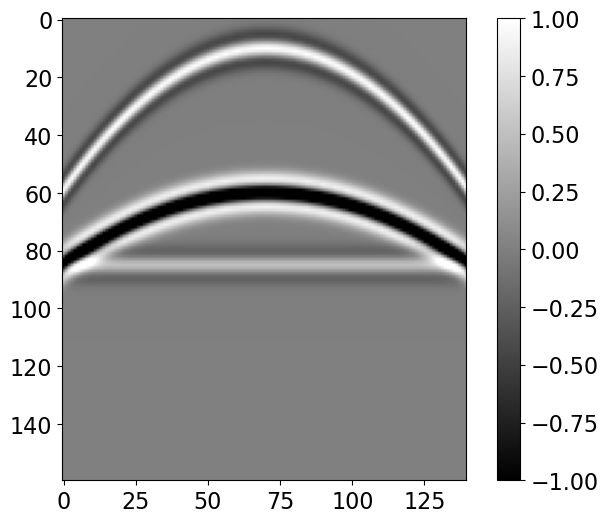

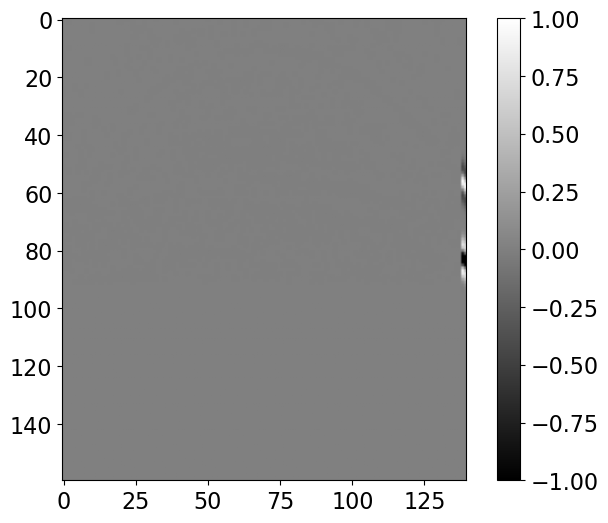

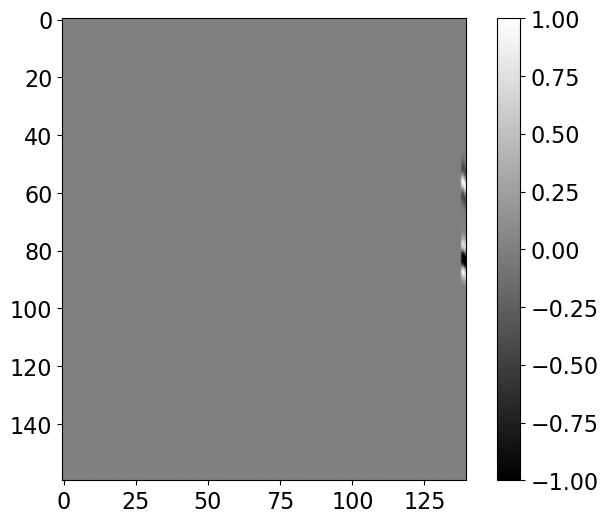

In [26]:
plt.figure()
plt.imshow(np.fft.fftshift(np.abs(x.ravel()[:nop1[0]*nop1[1]].reshape(nop1).T), axes=1))
plt.colorbar()
plt.axis('tight')

plt.figure()
plt.imshow(y.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-y1.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.imshow(y.T-yinv.T, cmap='gray',vmin=-1, vmax=1)
plt.colorbar();

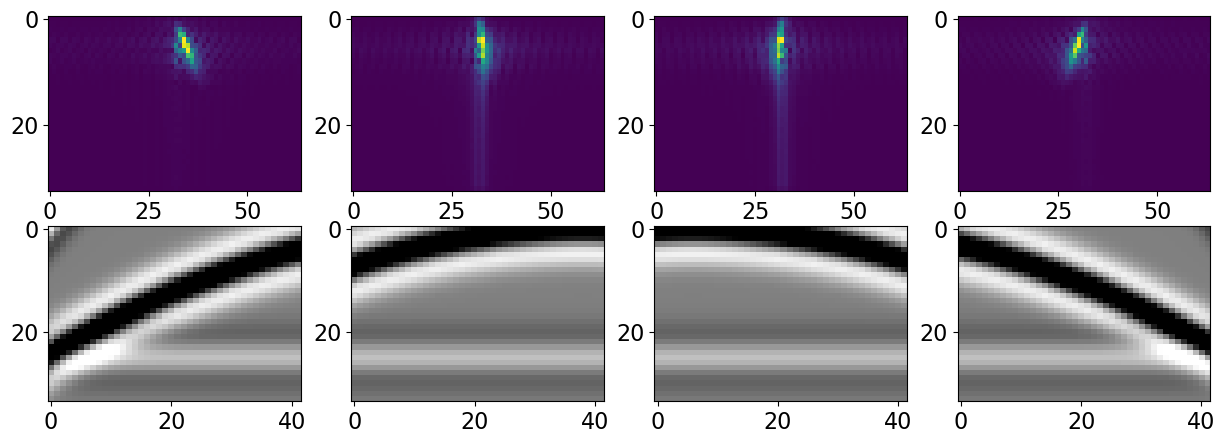

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(xreshape[i, 2]).T, axes=1))
    axs[0][i].axis('tight')
    axs[1][i].imshow(np.real((Op.H * xreshape[i, 2].ravel()).reshape(nwin)).T, cmap='gray', vmin=-1, vmax=1)
    axs[1][i].axis('tight');

## 3d patches

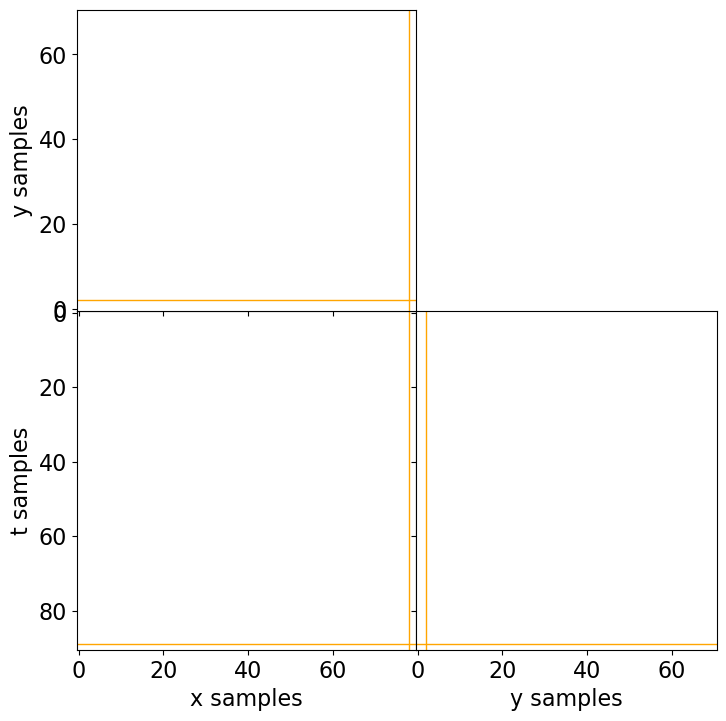

In [28]:
ny, nx, nt = 91, 80, 71
data = np.ones((ny, nx, nt))

dimsd = data.shape
nwin = (21, 10, 7)
nover = (7, 5, 3)
nwins = (6, 15, 17)
#dims = (nwins[0]*nwin[0], nwins[1]*nwin[1], nwins[2]*nwin[2])

Op = Identity(nwin[0]*nwin[1]*nwin[2], nwin[0]*nwin[1]*nwin[2])

nwins, dims, mwin_inends, dwin_inends = patch3d_design(dimsd, nwin, nover, nwin)
Sop = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
              tapertype=None)
S1op = Patch3D(Op.H, dims, dimsd, nwin, nover, nwin,
              tapertype='cosine')

y = S1op * np.ones(Sop.shape[1])
y = y.reshape(dimsd[0], dimsd[1], dimsd[2])

explode_volume(y, t=ny-2, x=nx-2, y=2)